<a href="https://colab.research.google.com/github/willwjy/Final-Project-Will/blob/main/PyCUDA_urban_analysis_penn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[link text](https://)### GPU programming for the urban analysis
1. Configure the computing enviornment
2. Import PyCUDA module
3. Hello world version of PyCUDA for slope estimation
4. Calculate the shadow distribution

By Xiaojiang Li, UPenn, Nov 11, 2024

#### Step 1. Prepare the modules

In [ ]:
!pip install pycuda
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.7 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1-cp311-cp311-linux_x86_64.whl size=660394 sha256=97a40fef06ca8f528ba09b623af9c17799057134a75a74a803a29a73844dc121
  Stored in directory: /root/.cache/pip/wheels/77/7e/6c/d2d1451ea6424cdc3d67b36c16fa7111eafdf2034bc3405666
Successfully built pycuda
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 92.7 MB/s eta 0:00:00


In [ ]:
from pycuda.compiler import SourceModule
import pycuda
from pycuda import gpuarray
from pycuda import compiler
import pycuda.autoinit             # PyCuda autoinit
import pycuda.driver as cuda       # PyCuda In, Out helpers
import os, os.path
import rasterio as rio
from osgeo import gdal
from osgeo.gdalconst import *
import numpy as np
import rasterio
import time
import math
# Load the Drive helper and mount
from google.colab import drive
import matplotlib.cm as colormap   # Library to plot
import numpy                       # Fast math library
import matplotlib.image as mpimg       # reading images to numpy arrays
import matplotlib.pyplot as plt        # to plot any graph
import scipy.ndimage as ndi            # to determine shape centrality
# matplotlib setup

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (8, 8)      # setting default size of plots

print("pycuda installed and ready to use.")

print("%d device(s) found." % cuda.Device.count())
for ordinal in range(cuda.Device.count()):
    dev = cuda.Device(ordinal)
    print ("Device #%d: %s" % (ordinal, dev.name()))
print (cuda)

pycuda installed and ready to use.
1 device(s) found.
Device #0: Tesla T4
<module 'pycuda.driver' from '/usr/local/lib/python3.11/dist-packages/pycuda/driver.py'>


Mount to your Google Drive

In [ ]:

# This will prompt for authorization.
drive.mount('/content/drive')

# replace "deeplearn-city/treepedia-workshop" by your own drive path
dsm_file = "/content/drive/MyDrive/Colab Notebooks/data/row11-col17.tif"
os.path.exists(dsm_file)

dsm_dataset = rio.open(dsm_file)

dsm_bounds = dsm_dataset.bounds
dsm_img = dsm_dataset.read(1)
print('The dsm bound is:', dsm_bounds)


transform = dsm_dataset.transform

# The pixel width and height (scale) can be found as follows:
pixel_width = transform[0]  # Scale in the x-direction
pixel_height = -transform[4]  # Scale in the y-direction (usually negative)

# You can calculate a unified scale if needed (average or reciprocal)
scale = 1 / pixel_width  # This will give you a scale factor


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The dsm bound is: BoundingBox(left=2712748.0, bottom=259294.0, right=2717948.0, top=264494.0)


In [ ]:
# !ls "/content/drive/MyDrive/Colab Notebooks/data"

In [ ]:
transform

Affine(2.0, 0.0, 2712748.0,
       0.0, -2.0, 264494.0)

#### Step 2: PyCUDA Kernel for Slope Calculation


In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# Define the CUDA kernel for slope calculation
kernel_code = """
__global__ void calculate_slope(float *dsm, float *slope, int width, int height, float cell_size) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x > 0 && x < width - 1 && y > 0 && y < height - 1) {
        // Calculate gradient in x and y directions
        float dzdx = (dsm[y * width + (x + 1)] - dsm[y * width + (x - 1)]) / (2 * cell_size);
        float dzdy = (dsm[(y + 1) * width + x] - dsm[(y - 1) * width + x]) / (2 * cell_size);

        // Calculate slope
        slope[y * width + x] = atan(sqrt(dzdx * dzdx + dzdy * dzdy)) * 180 / 3.14159;
    }
}
"""

# Compile the kernel
mod = SourceModule(kernel_code)
calculate_slope = mod.get_function("calculate_slope")

In [ ]:
dsm_dataset = rio.open(dsm_file)

dsm_bounds = dsm_dataset.bounds
dsm_img = dsm_dataset.read(1)
print('The dsm bound is:', dsm_bounds)


# Prepare data
dsm = dsm_img.astype(np.float32)
height, width = dsm.shape
cell_size = 1.0  # Assuming cell size is 1 meter; adjust according to DSM metadata

# Allocate memory on the GPU
d_dsm = cuda.mem_alloc(dsm.nbytes)
d_slope = cuda.mem_alloc(dsm.nbytes)

# Copy DSM data to GPU
cuda.memcpy_htod(d_dsm, dsm)

The dsm bound is: BoundingBox(left=2712748.0, bottom=259294.0, right=2717948.0, top=264494.0)


Choosing the block size dimensions in CUDA depends on several factors, including the structure of your data, the size of your computation, and the hardware limitations of your GPU.


CUDA’s warps (groups of 32 threads) run efficiently with blocks sized as multiples of 32.
- A common choice is (16,16) or (32,32), balancing parallelism and shared memory usage.
- A larger block size (e.g., (32,32)) reduces scheduling overhead but increases shared memory use.

In [ ]:
# Define block and grid size
block_size = (16, 16, 1) #	1 → Number of threads in the z-direction (which is not used in 2D computations).
grid_size = (int(np.ceil(width / block_size[0])), int(np.ceil(height / block_size[1])))

# Run the kernel
calculate_slope(d_dsm, d_slope, np.int32(width), np.int32(height), np.float32(cell_size), block=block_size, grid=grid_size)

In [ ]:
# Create an empty array for the result on the host
slope = np.empty_like(dsm)

# Copy result back to host
cuda.memcpy_dtoh(slope, d_slope)

# Free GPU memory
d_dsm.free()
d_slope.free()

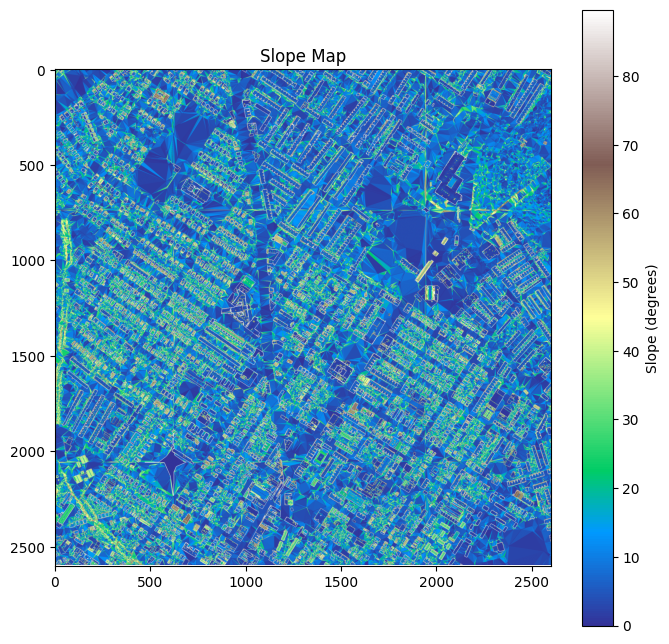

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(slope, cmap="terrain")
plt.colorbar(label="Slope (degrees)")
plt.title("Slope Map")
plt.show()


#### 3. Advanced: Compute the shadow distribution

In [ ]:
# Define the CUDA kernel for the shadow calculation
kernel_shadow = """
#define PI 3.1415926

__global__ void calculate_shadow(float *dsm, bool *shadow, int width, int height, float cell_size, float sun_azimuth, float sun_elevation) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    // Check if the thread is within the bounds of the image
    if (x >= width || y >= height)
        return;

    int idx = y * width + x;

    // Convert sun azimuth and elevation to radians
    float azimuth_rad = sun_azimuth * 3.14159 / 180.0;
    float elevation_rad = sun_elevation * 3.14159 / 180.0;

    // Direction of the shadow ray based on sun azimuth
    float dx = cos(azimuth_rad);
    float dy = sin(azimuth_rad);
    float dz = tan(elevation_rad);

    // Initial height at the current pixel
    float initial_height = dsm[idx];
    bool in_shadow = false;

    // Trace the shadow ray
    for (float t = cell_size; t < 2000.0f; t += cell_size) { // Limit tracing distance
        int x_offset = x + int(dx * t / cell_size);
        int y_offset = y + int(dy * t / cell_size);

        if (x_offset < 0 || x_offset >= width || y_offset < 0 || y_offset >= height)
            break;  // Out of bounds

        int offset_idx = y_offset * width + x_offset;

        // Calculate height along the ray
        float height_along_ray = initial_height + dz * t;

        // Check if there is a higher point along the path
        if (dsm[offset_idx] > height_along_ray) {
            in_shadow = true;
            break;
        }
    }

    // Store shadow result: 1 for shadow, 0 for no shadow
    shadow[idx] = in_shadow;
}
"""

# Compile the kernel
mod = SourceModule(kernel_shadow)
calculate_shadows = mod.get_function("calculate_shadow")

In [ ]:
# Prepare parameters and allocate memory
height, width = dsm_img.shape

# Allocate memory for input DSM and output shadow map
d_dsm = cuda.mem_alloc(dsm_img.nbytes)
d_shadow = cuda.mem_alloc(dsm_img.nbytes)  # Shadow result (boolean)

# Copy DSM to GPU
cuda.memcpy_htod(d_dsm, dsm_img)

# Initialize shadow output array on CPU
shadow_result = np.zeros_like(dsm_img, dtype=bool)

In [ ]:
# Sun parameters (angles in degrees)
sun_azimuth = 45.0       # Example: 45 degrees from the north
sun_elevation = 20.0     # Example: 30 degrees above the horizon
cell_size = 1.0          # Adjust based on DSM resolution, e.g., 1 meter per pixel


# Define block and grid size
block_size = (16, 16, 1)
grid_size = (int(np.ceil(width / block_size[0])), int(np.ceil(height / block_size[1])))


# Convert sun angles to float32 and launch the kernel
calculate_shadows(
    d_dsm, d_shadow, np.int32(width), np.int32(height),
    np.float32(cell_size), np.float32(sun_azimuth), np.float32(sun_elevation),
    block=block_size, grid=grid_size
)


In [ ]:
# Copy the shadow results back to the host
cuda.memcpy_dtoh(shadow_result, d_shadow)

# Free GPU memory
d_dsm.free()
d_shadow.free()

In [ ]:
binary_shadow = shadow_result.astype(np.uint8)  # 1 for True (shadow), 0 for False (non-shadow)


In [ ]:
shadow_result

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

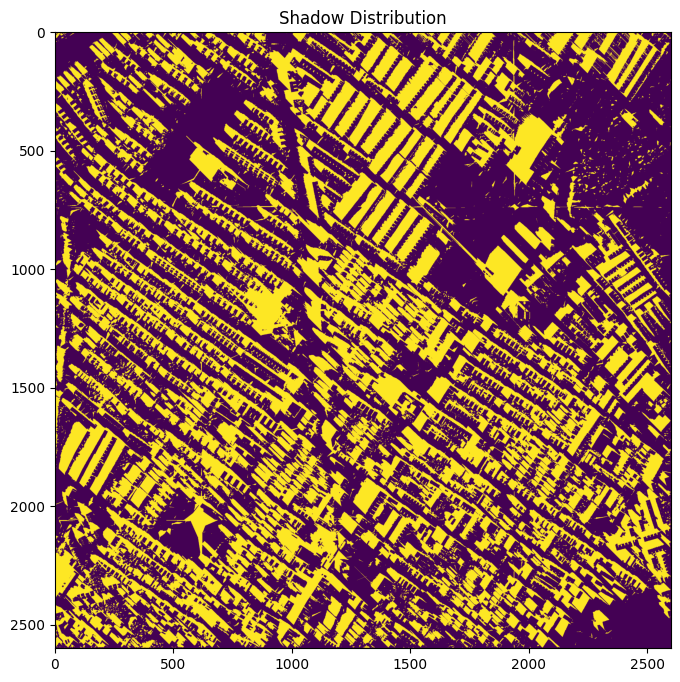

In [ ]:
# Display the binary shadow image
plt.imshow(shadow_result)
# plt.colorbar(label="Shadow (1=True, 0=False)")
plt.title("Shadow Distribution")
plt.show()

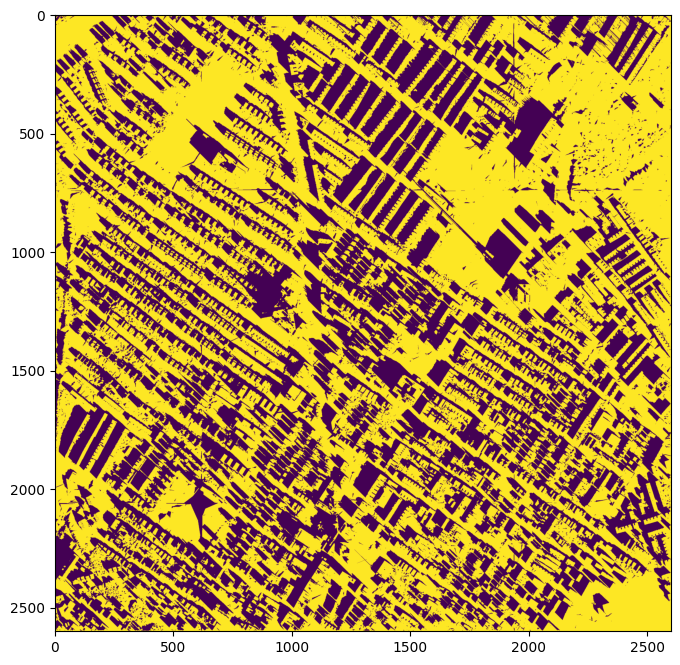

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(binary_shadow==0)
# plt.colorbar(label="Shadow (1=True, 0=False)")
# plt.title("Shadow Distribution")
plt.show()

#### Home work:
Think about how to export the results into a geotiff raster file